# Modélisation avec PyCaret – Bank Marketing

Ce notebook utilise la bibliothèque PyCaret pour créer un modèle de classification visant à prédire si un client va souscrire à un dépôt à terme ou non (`y`).


## Importation des modules et des données nettoyées

In [ ]:
from pycaret.classification import *
import pandas as pd


df = pd.read_csv("data/bank_marketing/bank/bank.csv", sep=';')

df.replace('unknown', pd.NA, inplace=True)

df = df.dropna()

df['y'].value_counts()

y
no     593
yes    171
Name: count, dtype: int64

## Initialisation de l’environnement PyCaret

In [2]:
clf = setup(
    data=df,
    target='y',
    session_id=42,
    verbose=False,
    categorical_features=['job', 'marital', 'education', 'default',
                          'housing', 'loan', 'contact', 'month', 'poutcome']
)

Lorsque tu exécutes setup(), PyCaret fait automatiquement :

La détection des types de colonnes (numérique, texte, booléen…)

Le prétraitement :

Encodage des colonnes catégorielles

Suppression/Imputation des valeurs manquantes

Séparation du jeu d'entraînement et de test

L'affichage du résumé des données traitées

La sauvegarde de cette "expérience" pour les étapes suivantes



## Comparaison automatique des modèles

PyCaret va tester plein de modèles (logistic regression, decision tree, random forest, etc.) et afficher leurs performances, en particulier l’accuracy.

In [ ]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8447,0.8728,0.8447,0.8414,0.8368,0.5157,0.5297,0.1100
lr,Logistic Regression,0.8389,0.8505,0.8389,0.8343,0.8295,0.4927,0.5079,0.6230
rf,Random Forest Classifier,0.8353,0.8804,0.8353,0.8166,0.8088,0.4163,0.4490,0.1350
ridge,Ridge Classifier,0.8334,0.8482,0.8334,0.8304,0.8263,0.4871,0.4997,0.0560
lda,Linear Discriminant Analysis,0.8296,0.8458,0.8296,0.8294,0.8265,0.4961,0.5030,0.0580
lightgbm,Light Gradient Boosting Machine,0.8222,0.8694,0.8222,0.8170,0.8159,0.4587,0.4666,0.2000
et,Extra Trees Classifier,0.8164,0.8611,0.8164,0.7938,0.7884,0.3537,0.3787,0.1260
ada,Ada Boost Classifier,0.8147,0.8348,0.8147,0.8125,0.8089,0.4407,0.4509,0.0910
dt,Decision Tree Classifier,0.7997,0.7347,0.7997,0.8128,0.8031,0.4502,0.4565,0.0570
dummy,Dummy Classifier,0.7753,0.5000,0.7753,0.6010,0.6771,0.0000,0.0000,0.0580


## Ce que fait le programme :
Entraîne tous les modèles de classification disponibles

Affiche un tableau de comparaison avec des métriques comme :

Accuracy (précision globale)

AUC (performance sur les classes)

Recall, Precision, etc.

Sauvegarde le meilleur modèle dans la variable best_model

## Résultats de la comparaison

Le tableau affiche les performances de tous les modèles testés automatiquement par PyCaret.  
Le modèle ayant la **meilleure accuracy** est sélectionné.  
Cela signifie qu'il prédit correctement la plus grande proportion de "yes" ou "no".


## Affichage du meilleur modèle

In [ ]:
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


## Visualiser les métriques du modèle

### Objectif : visualiser les erreurs du modèle

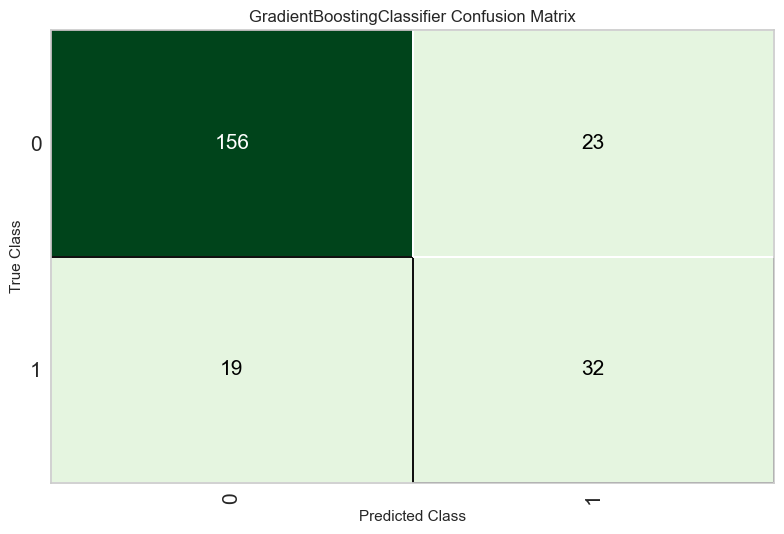

In [5]:
plot_model(best_model, plot='confusion_matrix')

Un tableau 2x2 qui compare les vraies réponses avec les prédictions du modèle :

|                                          | Prédit "no"           | Prédit "yes"          |
| ---------------------------------------- | --------------------- | --------------------- |
| **Vrai "no"** (clients qui ont refusé)   |  Vrais négatifs (TN) |  Faux positifs (FP)  |
| **Vrai "yes"** (clients qui ont accepté) |  Faux négatifs (FN)  |  Vrais positifs (TP) |


Interprétation :
- Les "vrais positifs" = bien prédits comme "yes"

- Les "faux négatifs" = le modèle a dit "no" alors que c’était "yes" → mauvais pour une campagne marketing !

Le modèle est meilleur s’il a :

peu de FN (ne pas rater des clients intéressés)

un bon équilibre entre TP et TN


### Objectif : mesurer la capacité de séparation entre "yes" et "no"

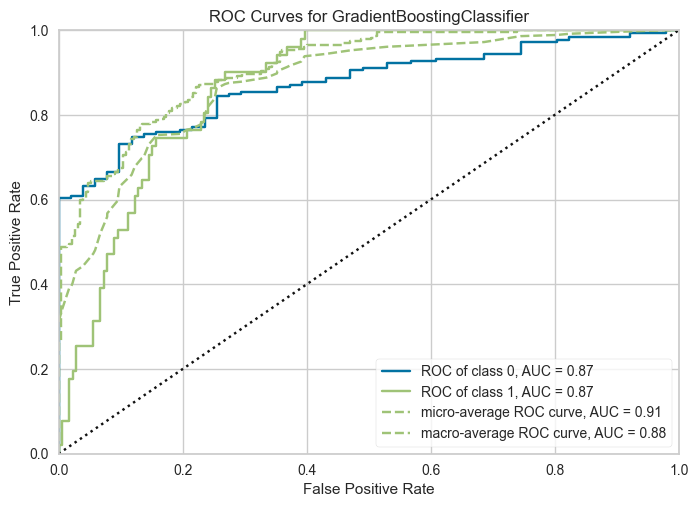

In [6]:
plot_model(best_model, plot='auc') 

C’est la courbe ROC (Receiver Operating Characteristic). L’AUC (area under the curve) donne une note de 0 à 1 :

 AUC = 1.0 = parfait

 AUC > 0.8 = très bon

 AUC ≈ 0.5 = modèle aléatoire

### interprétation :

- Si la courbe est en haut à gauche, le modèle sépare bien les clients intéressés des non intéressés.

- L’AUC est moins influencée par les déséquilibres de classes que l’accuracy.


### Objectif : voir quelles variables influencent le plus les prédictions

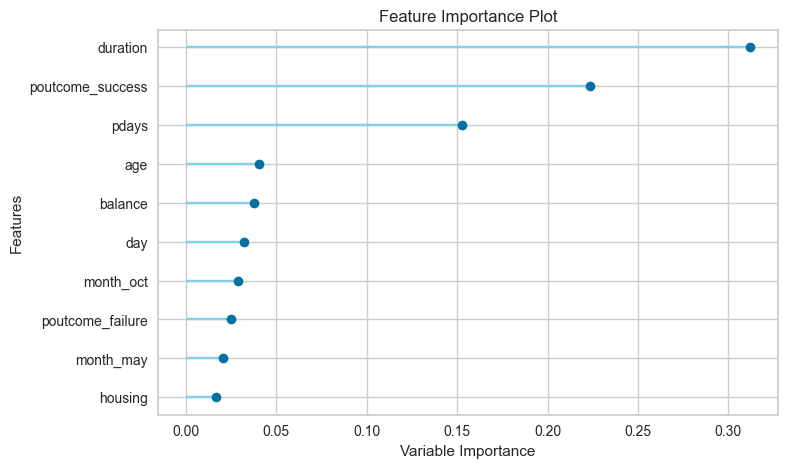

In [7]:
plot_model(best_model, plot='feature')

### Analyse des variables importantes (Feature Importance)

Le graphique montre que la variable `duration` est la plus influente dans les décisions du modèle.  
Cela signifie que les clients ayant eu de longs appels sont plus susceptibles de souscrire à l’offre.  
Les résultats des campagnes précédentes (`poutcome`) et le canal de communication (`contact`) sont aussi très prédictifs.

En revanche, des variables comme l’âge ou le niveau d’éducation ont un impact plus faible dans ce modèle.


### Objectif: voir comment le modèle apprend à mesure qu'on lui donne plus de données

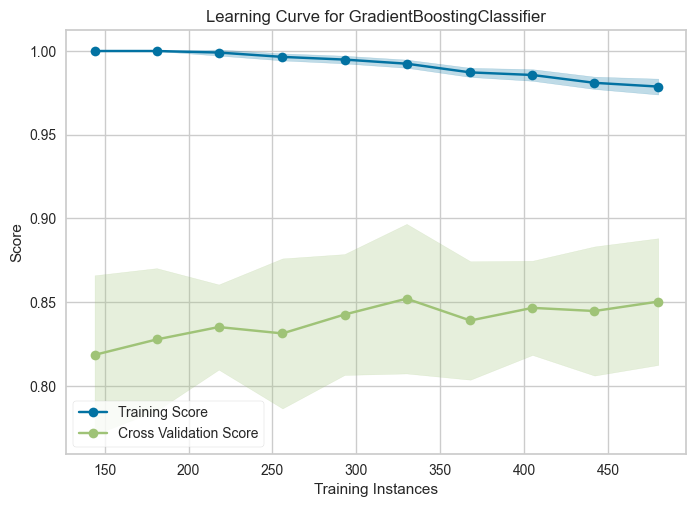

In [8]:
plot_model(best_model, plot='learning')

### Analyse de la courbe d'apprentissage

Le graphe montre que la performance du modèle augmente avec plus de données, puis se stabilise.  
Les courbes d'entraînement et de validation sont proches, ce qui indique une bonne généralisation.  
Cela signifie que le modèle n’est pas en situation de surapprentissage, et qu’il est capable de faire de bonnes prédictions sur de nouvelles données.


## Prédictions sur de nouvelles données

In [ ]:
final_model = finalize_model(best_model)

predictions = predict_model(final_model, data=df.sample(5))
predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,prediction_label,prediction_score
2055,48,technician,married,secondary,no,568,yes,no,cellular,2,sep,378,2,386,1,success,yes,yes,0.8282
1437,77,retired,married,tertiary,no,0,no,no,cellular,16,oct,847,1,60,1,success,yes,yes,0.8744
4456,37,management,married,primary,no,3953,yes,no,cellular,6,apr,610,2,138,1,failure,no,no,0.8993
1071,38,blue-collar,married,secondary,no,0,yes,no,cellular,13,may,57,5,349,1,other,no,no,0.9956
1905,46,management,married,tertiary,no,273,yes,no,cellular,18,mar,910,2,184,4,success,yes,yes,0.8771


## Conclusion

Grâce à PyCaret, nous avons :
- testé plusieurs modèles de classification,
- sélectionné automatiquement le modèle avec la meilleure performance,
- évalué sa précision (accuracy) et sa robustesse.

Ce modèle peut maintenant être utilisé pour prédire si de nouveaux clients vont souscrire à une offre ou non.
